## Setup and Imports

In [23]:
# Install required packages (run once)
!pip install gseapy statsmodels scikit-learn matplotlib seaborn scipy pandas numpy pydeseq2 -q

In [24]:
# Core data manipulation
import pandas as pd
import numpy as np

# Statistical analysis
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram
from statsmodels.stats.multitest import multipletests
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

# Machine learning
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Gene set enrichment
import gseapy as gp

# Settings
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

# Plot settings
plt.rcParams['figure.dpi'] = 100
sns.set_style('whitegrid')

---
## Task 1: Data Exploration
### Task 1.1: Load and Filter Genes

In [25]:
# Create results directory if it doesn't exist
import os
os.makedirs('results', exist_ok=True)
print("Results directory ready.")

Results directory ready.


In [26]:
# Load data
# Note: Obtain count data from TCGA-BLCA dataset
# The count file should be placed in data/ directory as 'tcga_blca_v2_exp_count.csv'
# Class data is already available

try:
    # Load count data and separate gene annotations from expression counts
    count_data_raw = pd.read_csv('data/tcga_blca_v2_exp_count.csv', index_col=0)
    
    # Separate gene annotations (non-numeric columns) from count data
    gene_annotations = count_data_raw.select_dtypes(exclude=['number'])
    count_data = count_data_raw.select_dtypes(include=['number'])
    
    # Load class data
    class_data = pd.read_csv('data/tcga_blca_v2_class.csv')
    
    print(f"Original data shape: {count_data.shape}")
    print(f"Samples: {count_data.shape[1]}, Genes: {count_data.shape[0]}")
    print(f"Gene annotations saved separately: {gene_annotations.shape}")
    print(f"\nClass distribution:")
    print(class_data['tumor_type'].value_counts())
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("\nPlease ensure 'tcga_blca_v2_exp_count.csv' is in the data/ directory")
    print("This file should contain gene expression counts with:")
    print("  - Genes as rows (index)")
    print("  - Samples as columns")

Original data shape: (60660, 90)
Samples: 90, Genes: 60660
Gene annotations saved separately: (60660, 3)

Class distribution:
tumor_type
Low Grade     50
High Grade    40
Name: count, dtype: int64


In [27]:
# Filter lowly expressed genes
# Criteria: Raw count > 5 in at least 10% of samples

def filter_low_expression(count_data, min_count=5, min_sample_fraction=0.1):
    """
    Filter genes with low expression.
    Keep genes with count > min_count in at least min_sample_fraction of samples.
    This follows the instruction: remove genes not expressed (count <= 5) in at least 10% of samples.
    """
    # Count samples where gene has count > threshold
    min_samples = int(count_data.shape[1] * min_sample_fraction)
    genes_pass = (count_data > min_count).sum(axis=1) >= min_samples
    
    filtered_data = count_data[genes_pass]
    
    print(f"Genes before filtering: {count_data.shape[0]}")
    print(f"Genes after filtering: {filtered_data.shape[0]}")
    print(f"Genes removed: {count_data.shape[0] - filtered_data.shape[0]}")
    print(f"Threshold: count > {min_count} in at least {min_samples} samples ({min_sample_fraction*100}%)")
    
    return filtered_data

filtered_count_data = filter_low_expression(count_data)

Genes before filtering: 60660
Genes after filtering: 28023
Genes removed: 32637
Threshold: count > 5 in at least 9 samples (10.0%)


### Task 1.2: CPM Normalization

In [28]:
def calculate_cpm(count_data):
    """Calculate Counts Per Million (CPM)."""
    return count_data.div(count_data.sum(axis=0), axis=1) * 1e6

def calculate_log_cpm(count_data, prior_count=2):
    """Calculate log2(CPM + prior_count)."""
    cpm = calculate_cpm(count_data)
    return np.log2(cpm + prior_count)

# Calculate normalized values
cpm_data = calculate_cpm(filtered_count_data)
log_cpm_data = calculate_log_cpm(filtered_count_data)

print(f"CPM data shape: {cpm_data.shape}")
print(f"Log2 CPM range: [{log_cpm_data.min().min():.2f}, {log_cpm_data.max().max():.2f}]")

CPM data shape: (28023, 90)
Log2 CPM range: [1.00, 16.45]


### Task 1.3: PCA Visualization

In [29]:
# Prepare data for PCA (samples as rows)
pca_input = log_cpm_data.T

# Standardize
scaler = StandardScaler()
pca_input_scaled = scaler.fit_transform(pca_input)

# Perform PCA
pca = PCA(n_components=10)
pca_result = pca.fit_transform(pca_input_scaled)
variance_explained = pca.explained_variance_ratio_ * 100

print(f"PC1 variance: {variance_explained[0]:.2f}%")
print(f"PC2 variance: {variance_explained[1]:.2f}%")
print(f"Cumulative (PC1-PC2): {variance_explained[:2].sum():.2f}%")

PC1 variance: 15.41%
PC2 variance: 7.13%
Cumulative (PC1-PC2): 22.54%


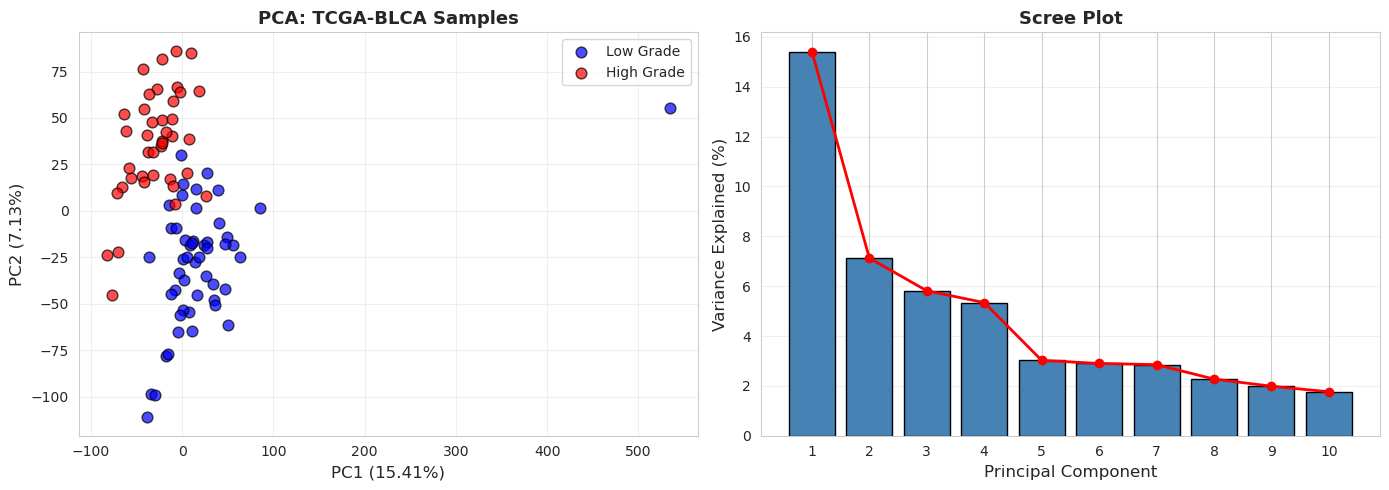

In [30]:
# Create PCA plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Match samples to tumor grades
sample_labels = []
for sample in pca_input.index:
    tumor_type = class_data[class_data['barcode'] == sample]['tumor_type'].values
    sample_labels.append(tumor_type[0] if len(tumor_type) > 0 else 'Unknown')

# Plot 1: PCA scatter
for grade, color in [('Low Grade', 'blue'), ('High Grade', 'red')]:
    mask = [label == grade for label in sample_labels]
    axes[0].scatter(pca_result[mask, 0], pca_result[mask, 1],
                   c=color, label=grade, s=60, alpha=0.7, edgecolors='black')

axes[0].set_xlabel(f'PC1 ({variance_explained[0]:.2f}%)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({variance_explained[1]:.2f}%)', fontsize=12)
axes[0].set_title('PCA: TCGA-BLCA Samples', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Scree plot
axes[1].bar(range(1, 11), variance_explained, color='steelblue', edgecolor='black')
axes[1].plot(range(1, 11), variance_explained, 'ro-', linewidth=2)
axes[1].set_xlabel('Principal Component', fontsize=12)
axes[1].set_ylabel('Variance Explained (%)', fontsize=12)
axes[1].set_title('Scree Plot', fontsize=13, fontweight='bold')
axes[1].set_xticks(range(1, 11))
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results/task1_pca_plot.png', dpi=300, bbox_inches='tight')
plt.show()

---
## Task 2: Clustering Analysis
### Task 2.1: Determine Optimal Clusters

In [31]:
# Prepare clustering data
cluster_data = log_cpm_data.T
cluster_data_scaled = StandardScaler().fit_transform(cluster_data)

# K-means silhouette analysis
silhouette_kmeans = []
k_range = range(2, 11)

print("K-means Silhouette Analysis:")
print("-" * 50)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=25, max_iter=300)
    cluster_labels = kmeans.fit_predict(cluster_data_scaled)
    silhouette_avg = silhouette_score(cluster_data_scaled, cluster_labels)
    silhouette_kmeans.append(silhouette_avg)
    print(f"k = {k}: Silhouette Score = {silhouette_avg:.4f}")

# Hierarchical clustering silhouette analysis
silhouette_hierarchical = []

print("\nHierarchical Clustering Silhouette Analysis:")
print("-" * 50)
for k in k_range:
    hierarchical = AgglomerativeClustering(n_clusters=k, linkage='average')
    cluster_labels = hierarchical.fit_predict(cluster_data_scaled)
    silhouette_avg = silhouette_score(cluster_data_scaled, cluster_labels)
    silhouette_hierarchical.append(silhouette_avg)
    print(f"k = {k}: Silhouette Score = {silhouette_avg:.4f}")

# Determine optimal k
optimal_k_kmeans = k_range[np.argmax(silhouette_kmeans)]
optimal_k_hierarchical = k_range[np.argmax(silhouette_hierarchical)]

print(f"\nOptimal k (K-means): {optimal_k_kmeans}")
print(f"Optimal k (Hierarchical): {optimal_k_hierarchical}")

K-means Silhouette Analysis:
--------------------------------------------------
k = 2: Silhouette Score = 0.6152
k = 2: Silhouette Score = 0.6152
k = 3: Silhouette Score = 0.0614
k = 3: Silhouette Score = 0.0614
k = 4: Silhouette Score = 0.0636
k = 4: Silhouette Score = 0.0636
k = 5: Silhouette Score = 0.0547
k = 5: Silhouette Score = 0.0547
k = 6: Silhouette Score = 0.0354
k = 6: Silhouette Score = 0.0354
k = 7: Silhouette Score = 0.0375
k = 7: Silhouette Score = 0.0375
k = 8: Silhouette Score = 0.0420
k = 8: Silhouette Score = 0.0420
k = 9: Silhouette Score = 0.0305
k = 9: Silhouette Score = 0.0305
k = 10: Silhouette Score = 0.0307

Hierarchical Clustering Silhouette Analysis:
--------------------------------------------------
k = 2: Silhouette Score = 0.6152
k = 3: Silhouette Score = 0.1951
k = 4: Silhouette Score = 0.1599
k = 5: Silhouette Score = 0.1069
k = 6: Silhouette Score = 0.0796
k = 7: Silhouette Score = 0.0693
k = 10: Silhouette Score = 0.0307

Hierarchical Clustering Silh

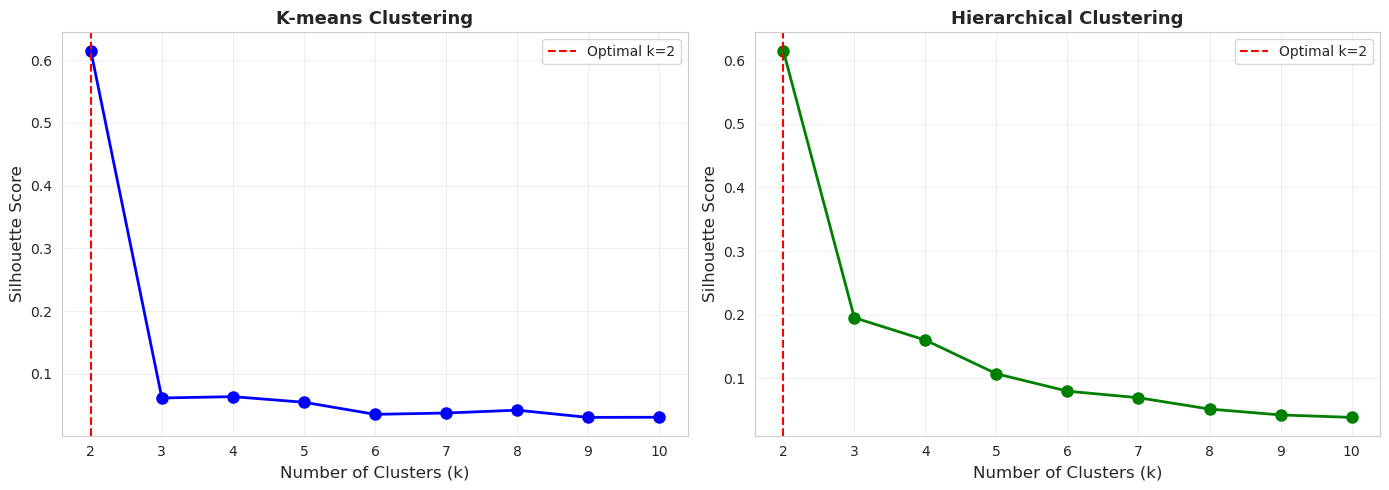

In [32]:
# Plot silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# K-means
axes[0].plot(k_range, silhouette_kmeans, 'bo-', linewidth=2, markersize=8)
axes[0].axvline(optimal_k_kmeans, color='red', linestyle='--', label=f'Optimal k={optimal_k_kmeans}')
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Silhouette Score', fontsize=12)
axes[0].set_title('K-means Clustering', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Hierarchical
axes[1].plot(k_range, silhouette_hierarchical, 'go-', linewidth=2, markersize=8)
axes[1].axvline(optimal_k_hierarchical, color='red', linestyle='--', label=f'Optimal k={optimal_k_hierarchical}')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Hierarchical Clustering', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/task2_silhouette_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### Task 2.2: Cluster Visualization

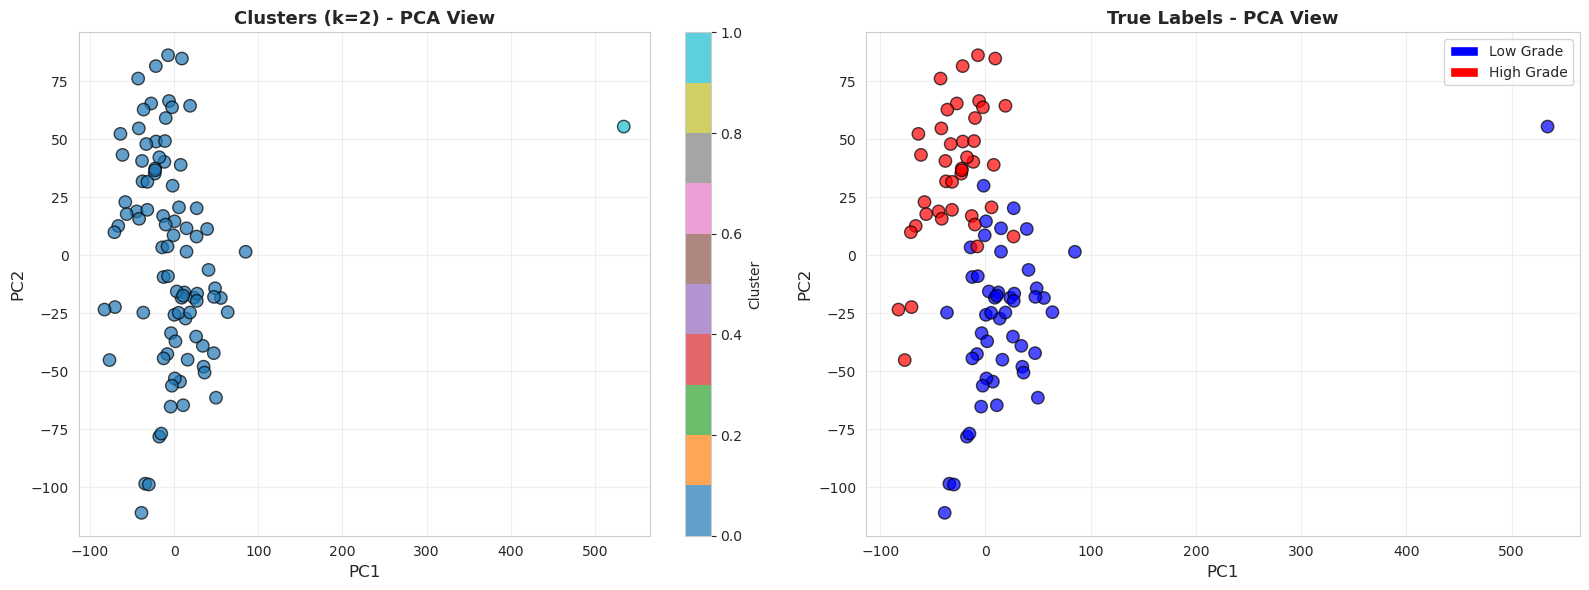

In [33]:
# Use optimal k for final clustering
optimal_k = optimal_k_kmeans

# Perform final clustering
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=25)
cluster_assignments = kmeans_final.fit_predict(cluster_data_scaled)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: PCA with cluster labels
pca_clusters = PCA(n_components=2)
pca_cluster_result = pca_clusters.fit_transform(cluster_data_scaled)

scatter = axes[0].scatter(pca_cluster_result[:, 0], pca_cluster_result[:, 1],
                         c=cluster_assignments, cmap='tab10', s=80, 
                         alpha=0.7, edgecolors='black')
axes[0].set_xlabel('PC1', fontsize=12)
axes[0].set_ylabel('PC2', fontsize=12)
axes[0].set_title(f'Clusters (k={optimal_k}) - PCA View', fontsize=13, fontweight='bold')
plt.colorbar(scatter, ax=axes[0], label='Cluster')
axes[0].grid(True, alpha=0.3)

# Plot 2: PCA colored by true labels
sample_colors = ['red' if label == 'High Grade' else 'blue' for label in sample_labels]
axes[1].scatter(pca_cluster_result[:, 0], pca_cluster_result[:, 1],
               c=sample_colors, s=80, alpha=0.7, edgecolors='black')
axes[1].set_xlabel('PC1', fontsize=12)
axes[1].set_ylabel('PC2', fontsize=12)
axes[1].set_title('True Labels - PCA View', fontsize=13, fontweight='bold')

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', label='Low Grade'),
                  Patch(facecolor='red', label='High Grade')]
axes[1].legend(handles=legend_elements)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/task2_cluster_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1200x1000 with 0 Axes>

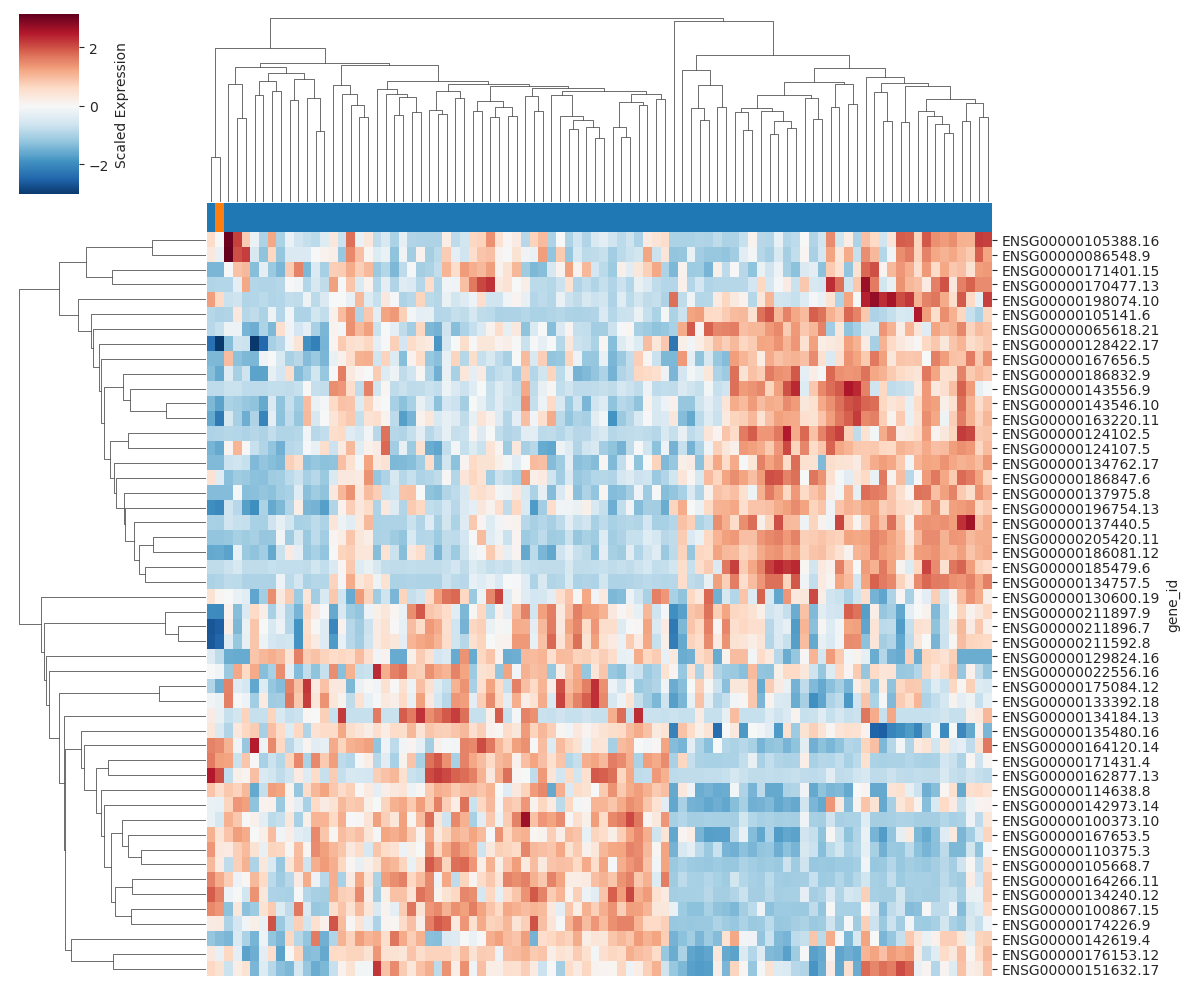

In [34]:
# Heatmap visualization
# Select top 50 most variable genes for visualization
gene_variance = log_cpm_data.var(axis=1)
top_genes = gene_variance.nlargest(50).index
heatmap_data = log_cpm_data.loc[top_genes, :]

# Standardize for better visualization
heatmap_data_scaled = (heatmap_data - heatmap_data.mean(axis=1).values.reshape(-1, 1)) / heatmap_data.std(axis=1).values.reshape(-1, 1)

# Create annotation for clusters
cluster_colors = [f'C{c}' for c in cluster_assignments]

plt.figure(figsize=(12, 10))
sns.clustermap(heatmap_data_scaled, 
               col_colors=cluster_colors,
               cmap='RdBu_r', 
               center=0,
               cbar_kws={'label': 'Scaled Expression'},
               figsize=(12, 10),
               xticklabels=False,
               yticklabels=True)

plt.savefig('results/task2_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

### Task 2.3: Cluster Entropy

Cluster Entropy Analysis:
Total Entropy: 0.9816
Maximum Possible Entropy per Cluster: 1.0000
Normalized Entropy: 0.9816

Cluster 0:
  Size: 89
  Entropy: 0.9926
  Composition: {np.str_('High Grade'): np.int64(40), np.str_('Low Grade'): np.int64(49)}

Cluster 1:
  Size: 1
  Entropy: 0.0000
  Composition: {np.str_('Low Grade'): np.int64(1)}


Confusion Matrix:
true_label  High Grade  Low Grade
cluster                          
0                   40         49
1                    0          1


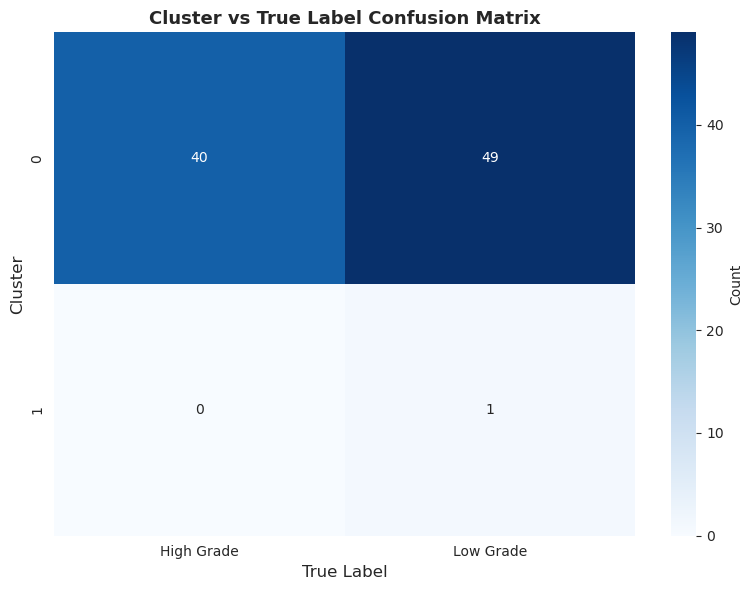

In [35]:
def compute_entropy(cluster_assignments, true_labels):
    """
    Compute entropy as defined in the lecture notes.
    For each cluster j: e_j = -sum(p_ij * log2(p_ij)) where p_ij is the probability
    that a member of cluster j belongs to class i.
    Total entropy: e = sum((m_j/m) * e_j) where m_j is cluster size and m is total samples.
    Lower entropy indicates better alignment with known classes.
    """
    # Get unique clusters and labels
    clusters = np.unique(cluster_assignments)
    labels = np.unique(true_labels)
    
    m = len(cluster_assignments)  # Total number of samples
    total_entropy = 0
    
    cluster_stats = []
    
    # Compute weighted average of cluster entropies
    for cluster in clusters:
        cluster_mask = cluster_assignments == cluster
        m_j = cluster_mask.sum()  # Number of samples in cluster j
        
        # Get class distribution within this cluster
        label_composition = {}
        cluster_entropy = 0
        
        for label in labels:
            # Count samples in this cluster with this true label
            n_ij = np.sum((true_labels == label) & (cluster_assignments == cluster))
            
            if n_ij > 0:
                label_composition[label] = n_ij
                # p_ij = probability that a member of cluster j belongs to class i
                p_ij = n_ij / m_j
                cluster_entropy -= p_ij * np.log2(p_ij)
        
        # Add weighted cluster entropy to total
        total_entropy += (m_j / m) * cluster_entropy
        
        cluster_stats.append({
            'Cluster': cluster,
            'Size': m_j,
            'Entropy': cluster_entropy,
            'Composition': label_composition
        })
    
    return total_entropy, cluster_stats

# Compute total entropy (as per lecture notes formula)
# Total entropy = sum((m_j/m) * e_j) where e_j is entropy of cluster j
total_entropy, cluster_info = compute_entropy(cluster_assignments, np.array(sample_labels))

# Maximum possible entropy per cluster (when classes are evenly distributed)
n_labels = len(np.unique(sample_labels))
max_entropy_per_cluster = np.log2(n_labels)

print("Cluster Entropy Analysis:")
print("="*60)
print(f"Total Entropy: {total_entropy:.4f}")
print(f"Maximum Possible Entropy per Cluster: {max_entropy_per_cluster:.4f}")
print(f"Normalized Entropy: {total_entropy/max_entropy_per_cluster:.4f}")
print()

for info in cluster_info:
    print(f"Cluster {info['Cluster']}:")
    print(f"  Size: {info['Size']}")
    print(f"  Entropy: {info['Entropy']:.4f}")
    print(f"  Composition: {info['Composition']}")
    print()

# Confusion matrix
confusion = pd.crosstab(cluster_assignments, sample_labels, rownames=['cluster'], colnames=['true_label'])
print("\nConfusion Matrix:")
print(confusion)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.xlabel('True Label', fontsize=12)
plt.ylabel('Cluster', fontsize=12)
plt.title('Cluster vs True Label Confusion Matrix', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('results/task2_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

---
## Task 3: Differential Expression Analysis
### Task 3.1: Perform DEG Analysis

In [36]:
def perform_deg_analysis(count_data, cpm_data, class_data, fdr_threshold=0.01, logfc_threshold=1):
    """
    Perform differential expression analysis using DESeq2.
    Uses PyDESeq2 implementation for proper RNA-seq count-based analysis
    with negative binomial modeling and dispersion estimation.
    """
    # Separate samples by group
    low_grade_samples = class_data[class_data['tumor_type'] == 'Low Grade']['barcode'].values
    high_grade_samples = class_data[class_data['tumor_type'] == 'High Grade']['barcode'].values
    
    # Filter samples present in data
    low_grade_samples = [s for s in low_grade_samples if s in count_data.columns]
    high_grade_samples = [s for s in high_grade_samples if s in count_data.columns]
    
    print(f"Low Grade samples: {len(low_grade_samples)}")
    print(f"High Grade samples: {len(high_grade_samples)}")
    
    # Prepare data for DESeq2: samples as rows, genes as columns
    all_samples = list(low_grade_samples) + list(high_grade_samples)
    counts_for_deseq = count_data[all_samples].T  # Transpose to samples x genes
    
    # Create metadata dataframe
    metadata = pd.DataFrame({
        'condition': ['Low_Grade'] * len(low_grade_samples) + ['High_Grade'] * len(high_grade_samples)
    }, index=all_samples)
    
    print(f"\nRunning DESeq2 analysis...")
    print(f"Count matrix shape: {counts_for_deseq.shape}")
    print(f"Genes: {counts_for_deseq.shape[1]}, Samples: {counts_for_deseq.shape[0]}")
    
    # Run DESeq2
    dds = DeseqDataSet(
        counts=counts_for_deseq,
        metadata=metadata,
        design_factors='condition',
        n_cpus=4
    )
    dds.deseq2()
    
    # Get statistical results (High Grade vs Low Grade)
    stat_res = DeseqStats(
        dds,
        contrast=['condition', 'High_Grade', 'Low_Grade'],
        n_cpus=4
    )
    stat_res.summary()
    
    # Extract results
    deg_results = stat_res.results_df.copy()
    
    # Rename columns to match expected format
    deg_results = deg_results.rename(columns={
        'log2FoldChange': 'logFC',
        'pvalue': 'pvalue',
        'padj': 'FDR',
        'stat': 'wald_statistic',
        'baseMean': 'baseMean'
    })
    
    # Add mean expression for each group
    deg_results['mean_Low_Grade'] = count_data[low_grade_samples].mean(axis=1)
    deg_results['mean_High_Grade'] = count_data[high_grade_samples].mean(axis=1)
    
    # Sort by FDR
    deg_results.sort_values('FDR', inplace=True)
    
    # Filter significant DEGs
    deg_filtered = deg_results[
        (deg_results['FDR'] < fdr_threshold) & 
        (abs(deg_results['logFC']) > logfc_threshold)
    ]
    
    return deg_results, deg_filtered

# Perform DEG analysis
print("Performing Differential Expression Analysis...")
print("="*60)

deg_results, deg_filtered = perform_deg_analysis(
    filtered_count_data, 
    cpm_data, 
    class_data
)

# Save results
deg_results.to_csv("results/task3_deg_all_results.csv")
deg_filtered.to_csv("results/task3_deg_significant.csv")

# Summary
print(f"\nTotal genes analyzed: {len(deg_results)}")
print(f"Significant DEGs (FDR < 0.01, |logFC| > 1): {len(deg_filtered)}")
print(f"  Upregulated: {(deg_filtered['logFC'] > 1).sum()}")
print(f"  Downregulated: {(deg_filtered['logFC'] < -1).sum()}")
print(f"\nTop 10 upregulated genes:")
print(deg_filtered.nlargest(10, 'logFC')[['logFC', 'FDR']])
print(f"\nTop 10 downregulated genes:")
print(deg_filtered.nsmallest(10, 'logFC')[['logFC', 'FDR']])

Performing Differential Expression Analysis...
Low Grade samples: 50
High Grade samples: 40

Running DESeq2 analysis...
Count matrix shape: (90, 28023)
Genes: 28023, Samples: 90
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
Fitting dispersions...
... done in 3.25 seconds.

Fitting dispersion trend curve...
... done in 3.25 seconds.

Fitting dispersion trend curve...
... done in 0.23 seconds.

Fitting MAP dispersions...
... done in 0.23 seconds.

Fitting MAP dispersions...
... done in 3.51 seconds.

Fitting LFCs...
... done in 3.51 seconds.

Fitting LFCs...
... done in 2.02 seconds.

Calculating cook's distance...
... done in 0.05 seconds.

Replacing 3346 outlier genes.

... done in 2.02 seconds.

Calculating cook's distance...
... done in 0.05 seconds.

Replacing 3346 outlier genes.

Fitting dispersions...
Fitting dispersions...
... done in 0.37 seconds.

Fitting MAP dispersions...
... done in 0.37 seconds.

Fitting MAP dispersions...
... done in 0.40 seconds.

Fitting LFCs...
... done in 0.40 seconds.

Fitting LFCs...
... done in 0.35 seconds.

Running Wald tests...
... done in 0.35 seconds.

Running Wald tests...
... done in 0.51 

Log2 fold change & Wald test p-value: condition High_Grade vs Low_Grade
                       baseMean  log2FoldChange     lfcSE      stat  \
gene_id                                                               
ENSG00000000003.15  5287.092090       -1.294952  0.186970 -6.925985   
ENSG00000000419.13  2138.447417        0.162429  0.112332  1.445966   
ENSG00000000457.14   610.210653       -0.512470  0.136697 -3.748950   
ENSG00000000460.17   565.186753       -0.337280  0.208527 -1.617444   
ENSG00000000938.13   513.311135        0.431644  0.220100  1.961124   
...                         ...             ...       ...       ...   
ENSG00000288658.1     19.640827        0.304029  0.376583  0.807335   
ENSG00000288663.1     23.123976       -0.847136  0.172137 -4.921291   
ENSG00000288670.1    248.803102       -0.517064  0.189629 -2.726710   
ENSG00000288674.1      3.945905       -0.324341  0.245541 -1.320925   
ENSG00000288675.1     28.590177        0.219562  0.198309  1.107171   

    

In [37]:
# Map Ensembl IDs to gene symbols for enrichment analysis
# Create mapping dictionary
ensembl_to_symbol = gene_annotations['gene_name'].to_dict()

# Add gene symbols to DEG results
deg_results_with_symbols = deg_results.copy()
deg_results_with_symbols['gene_symbol'] = deg_results_with_symbols.index.map(ensembl_to_symbol)

# Filter out genes without symbols (NaN)
deg_results_with_symbols = deg_results_with_symbols.dropna(subset=['gene_symbol'])

print(f"DEGs with gene symbols: {deg_results_with_symbols.shape[0]} / {deg_results.shape[0]}")
print(f"\nExample mappings:")
print(deg_results_with_symbols[['gene_symbol', 'logFC', 'FDR']].head())

DEGs with gene symbols: 28023 / 28023

Example mappings:
                   gene_symbol     logFC           FDR
gene_id                                               
ENSG00000185479.6        KRT6B  9.445142  3.790388e-67
ENSG00000162877.13      PM20D1 -8.693040  1.676086e-66
ENSG00000169594.13        BNC1  7.432975  1.876873e-65
ENSG00000229647.2      MYOSLID  4.872094  5.151860e-61
ENSG00000166863.13        TAC3 -9.352674  1.824182e-58


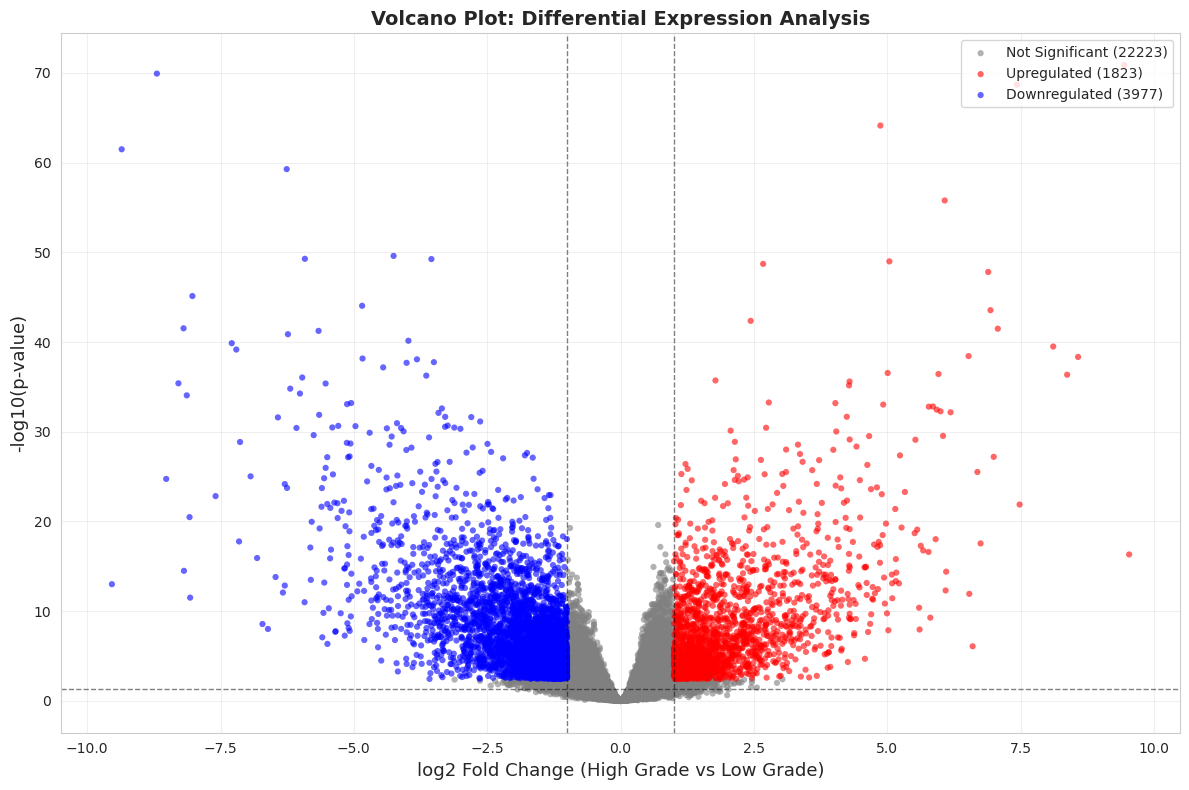

In [38]:
# Volcano plot
deg_results['color'] = 'Not Significant'
deg_results.loc[
    (deg_results['FDR'] < 0.01) & (deg_results['logFC'] > 1), 'color'
] = 'Upregulated'
deg_results.loc[
    (deg_results['FDR'] < 0.01) & (deg_results['logFC'] < -1), 'color'
] = 'Downregulated'

fig, ax = plt.subplots(figsize=(12, 8))

colors = {'Not Significant': 'gray', 'Upregulated': 'red', 'Downregulated': 'blue'}

for category, color in colors.items():
    mask = deg_results['color'] == category
    ax.scatter(deg_results.loc[mask, 'logFC'],
               -np.log10(deg_results.loc[mask, 'pvalue']),
               c=color, alpha=0.6, s=20,
               label=f'{category} ({mask.sum()})',
               edgecolors='none')

# Threshold lines
ax.axhline(-np.log10(0.05), color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(-1, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(1, color='black', linestyle='--', linewidth=1, alpha=0.5)

ax.set_xlabel('log2 Fold Change (High Grade vs Low Grade)', fontsize=13)
ax.set_ylabel('-log10(p-value)', fontsize=13)
ax.set_title('Volcano Plot: Differential Expression Analysis', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/task3_volcano_plot.png', dpi=300, bbox_inches='tight')
plt.show()

### Task 3.2: PCA with DEGs Only

Number of DEGs for PCA: 5800


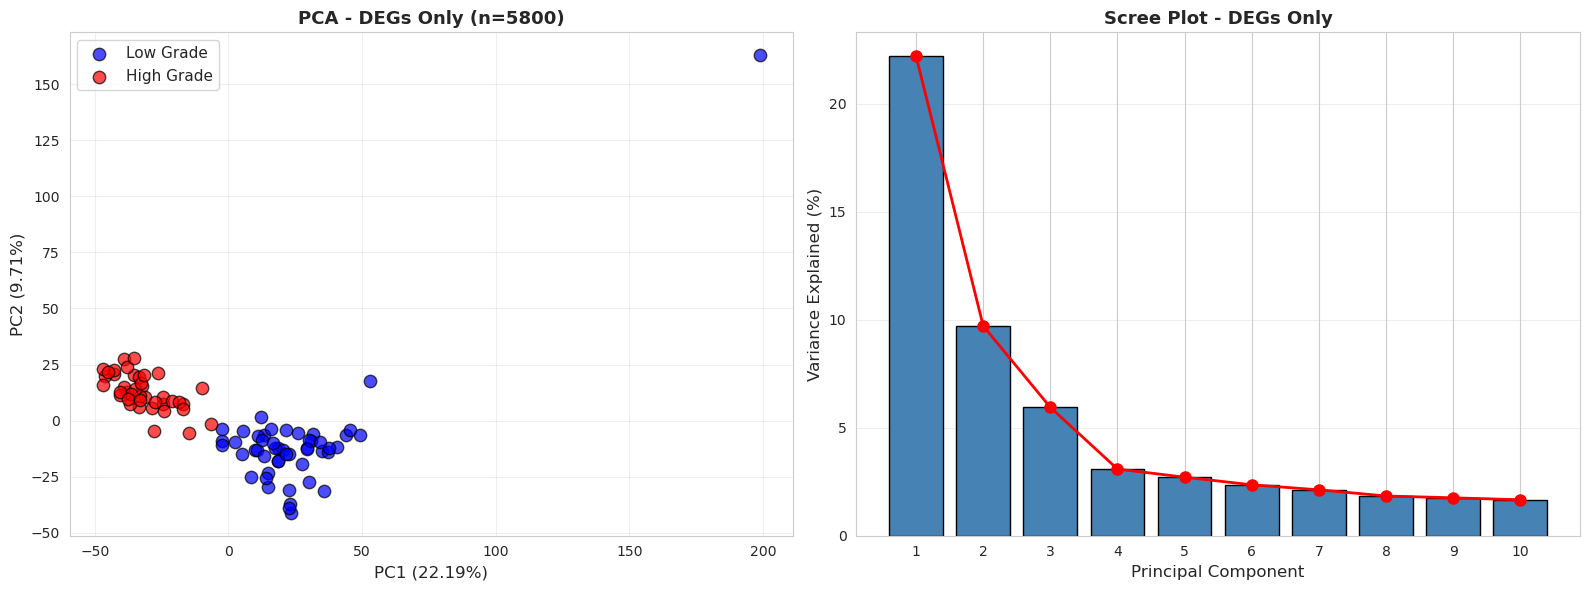


PC1 variance explained (DEGs): 22.19%
PC2 variance explained (DEGs): 9.71%
Cumulative (PC1-PC2): 31.91%


In [39]:
# Extract DEGs and subset data
deg_genes = deg_filtered.index.tolist()
deg_cpm = log_cpm_data.loc[deg_genes, :]

print(f"Number of DEGs for PCA: {len(deg_genes)}")

# Perform PCA
pca_input_deg = deg_cpm.T
scaler_deg = StandardScaler()
pca_input_deg_scaled = scaler_deg.fit_transform(pca_input_deg)

pca_deg = PCA(n_components=10)
pca_deg_result = pca_deg.fit_transform(pca_input_deg_scaled)
variance_explained_deg = pca_deg.explained_variance_ratio_ * 100

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: PCA with DEGs
for grade, color in [('Low Grade', 'blue'), ('High Grade', 'red')]:
    mask = [label == grade for label in sample_labels]
    axes[0].scatter(pca_deg_result[mask, 0], pca_deg_result[mask, 1],
                   c=color, label=grade, s=80, alpha=0.7, edgecolors='black')

axes[0].set_xlabel(f'PC1 ({variance_explained_deg[0]:.2f}%)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({variance_explained_deg[1]:.2f}%)', fontsize=12)
axes[0].set_title(f'PCA - DEGs Only (n={len(deg_genes)})', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Scree plot
axes[1].bar(range(1, 11), variance_explained_deg, color='steelblue', edgecolor='black')
axes[1].plot(range(1, 11), variance_explained_deg, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Principal Component', fontsize=12)
axes[1].set_ylabel('Variance Explained (%)', fontsize=12)
axes[1].set_title('Scree Plot - DEGs Only', fontsize=13, fontweight='bold')
axes[1].set_xticks(range(1, 11))
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results/task3_pca_degs.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPC1 variance explained (DEGs): {variance_explained_deg[0]:.2f}%")
print(f"PC2 variance explained (DEGs): {variance_explained_deg[1]:.2f}%")
print(f"Cumulative (PC1-PC2): {variance_explained_deg[:2].sum():.2f}%")

---
## Task 4: Gene Set Enrichment Analysis
### Task 4.1: GO Enrichment

In [40]:
def perform_go_enrichment(deg_filtered, direction='all'):
    """
    Perform GO enrichment analysis using GSEApy.
    deg_filtered should have 'gene_symbol' column.
    """
    # Select genes based on direction
    if direction == 'up':
        gene_list = deg_filtered[deg_filtered['logFC'] > 0]['gene_symbol'].dropna().tolist()
        label = "Upregulated"
    elif direction == 'down':
        gene_list = deg_filtered[deg_filtered['logFC'] < 0]['gene_symbol'].dropna().tolist()
        label = "Downregulated"
    else:
        gene_list = deg_filtered['gene_symbol'].dropna().tolist()
        label = "All DEGs"
    
    print(f"GO Enrichment Analysis - {label}")
    print(f"Number of genes: {len(gene_list)}")
    print("-" * 60)
    
    # Perform enrichment
    gene_sets = [
        'GO_Biological_Process_2023',
        'GO_Molecular_Function_2023',
        'GO_Cellular_Component_2023'
    ]
    
    results_dict = {}
    
    for gene_set in gene_sets:
        print(f"Analyzing {gene_set}...")
        try:
            enr = gp.enrichr(
                gene_list=gene_list,
                gene_sets=gene_set,
                organism='human',
                outdir=None,
                cutoff=0.05,
                no_plot=True
            )
            
            sig_results = enr.results[enr.results['Adjusted P-value'] < 0.05]
            results_dict[gene_set] = sig_results
            print(f"  Found {len(sig_results)} significant terms")
            
        except Exception as e:
            print(f"  Error: {e}")
    
    return results_dict

# Perform GO enrichment using gene symbols
# Use deg_results_with_symbols instead of deg_filtered
deg_filtered_with_symbols = deg_results_with_symbols[
    (deg_results_with_symbols['FDR'] < 0.01) & 
    (np.abs(deg_results_with_symbols['logFC']) > 1)
]

print("="*60)
go_results_all = perform_go_enrichment(deg_filtered_with_symbols, direction='all')
print("="*60)

GO Enrichment Analysis - All DEGs
Number of genes: 5800
------------------------------------------------------------
Analyzing GO_Biological_Process_2023...
  Found 1 significant terms
Analyzing GO_Molecular_Function_2023...
  Found 1 significant terms
Analyzing GO_Molecular_Function_2023...
  Found 0 significant terms
Analyzing GO_Cellular_Component_2023...
  Found 0 significant terms
Analyzing GO_Cellular_Component_2023...
  Found 0 significant terms
  Found 0 significant terms


In [41]:
# Save and display results
if 'GO_Biological_Process_2023' in go_results_all:
    go_bp_results = go_results_all['GO_Biological_Process_2023']
    go_bp_results.to_csv('results/task4_go_enrichment_bp.csv', index=False)
    
    print("\nTop 20 Enriched GO Biological Processes:")
    print("="*60)
    print(go_bp_results.head(20)[['Term', 'Adjusted P-value', 'Overlap', 'Combined Score']])


Top 20 Enriched GO Biological Processes:
                                 Term  Adjusted P-value Overlap  \
0  Epidermis Development (GO:0008544)          0.036638   44/85   

   Combined Score  
0       30.976485  


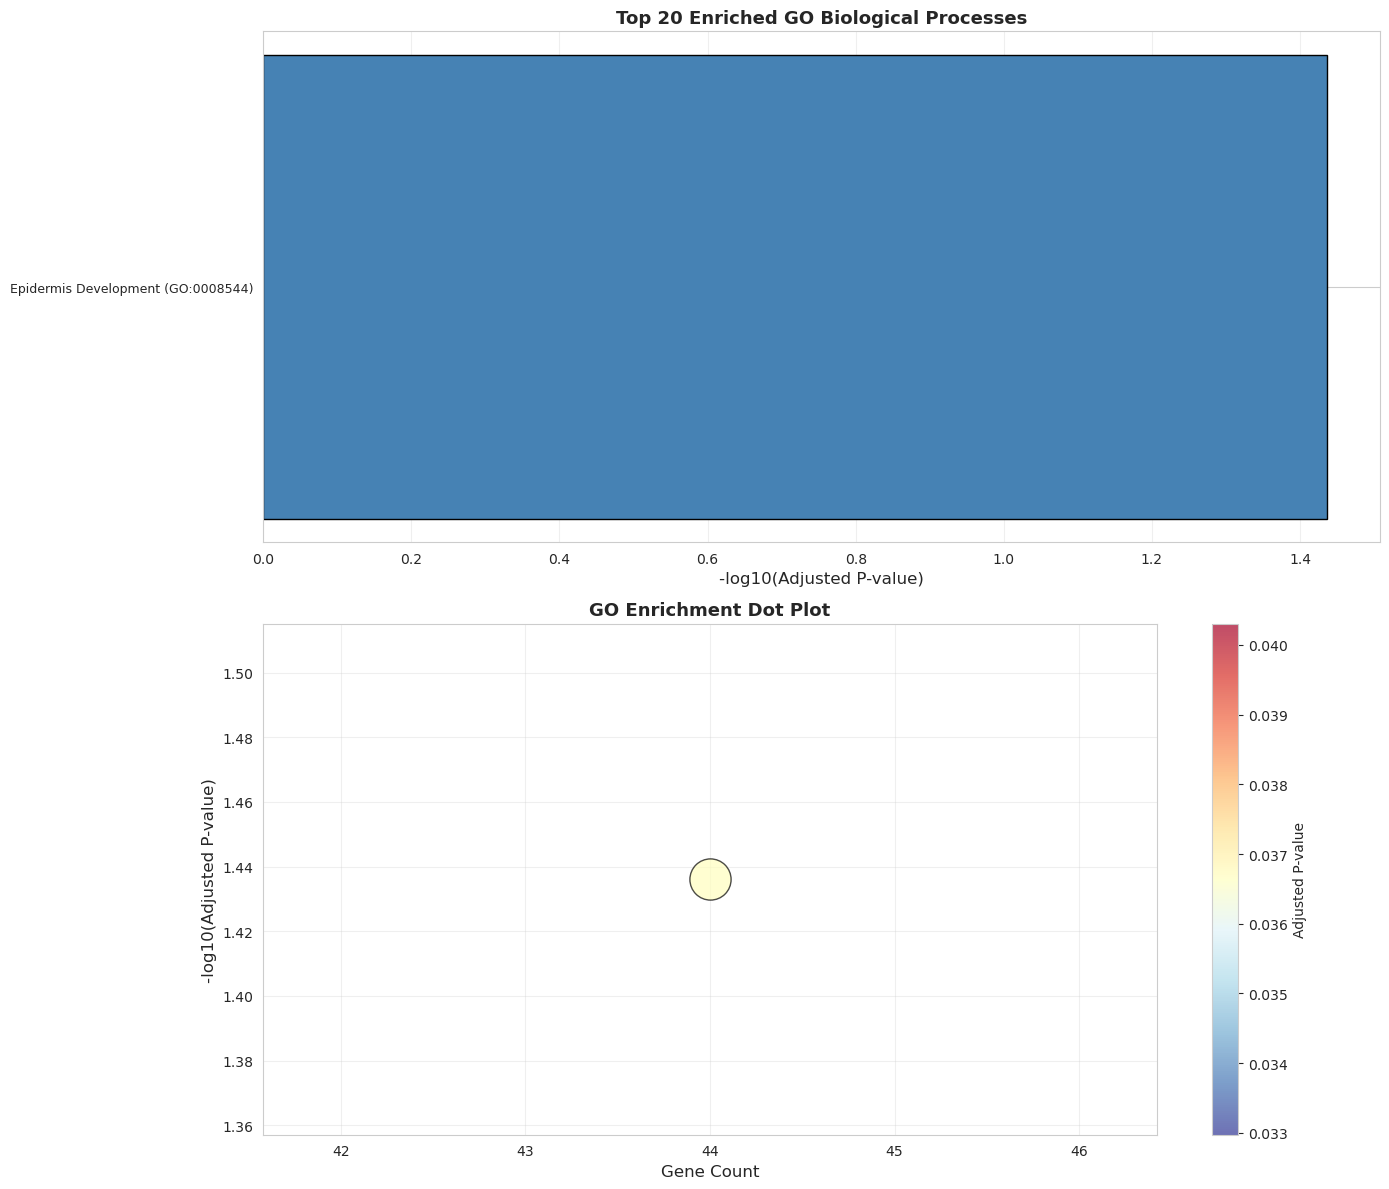

In [42]:
# Visualize GO enrichment results
if 'GO_Biological_Process_2023' in go_results_all and not go_results_all['GO_Biological_Process_2023'].empty:
    
    results = go_results_all['GO_Biological_Process_2023'].head(20).copy()
    results['-log10(FDR)'] = -np.log10(results['Adjusted P-value'])
    results['Gene_Count'] = results['Overlap'].apply(lambda x: int(x.split('/')[0]))
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    # Bar plot
    axes[0].barh(range(len(results)), results['-log10(FDR)'], color='steelblue', edgecolor='black')
    axes[0].set_yticks(range(len(results)))
    axes[0].set_yticklabels(results['Term'], fontsize=9)
    axes[0].set_xlabel('-log10(Adjusted P-value)', fontsize=12)
    axes[0].set_title('Top 20 Enriched GO Biological Processes', fontsize=13, fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(True, alpha=0.3, axis='x')
    
    # Dot plot
    scatter = axes[1].scatter(results['Gene_Count'], results['-log10(FDR)'],
                             s=results['Gene_Count']*20, 
                             c=results['Adjusted P-value'],
                             cmap='RdYlBu_r', alpha=0.7, edgecolors='black')
    axes[1].set_xlabel('Gene Count', fontsize=12)
    axes[1].set_ylabel('-log10(Adjusted P-value)', fontsize=12)
    axes[1].set_title('GO Enrichment Dot Plot', fontsize=13, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[1], label='Adjusted P-value')
    
    plt.tight_layout()
    plt.savefig('results/task4_go_enrichment_plots.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No significant GO terms found for visualization.")

### Task 4.2: Biological Interpretation

In [43]:
# Categorize GO terms by cancer relevance
def analyze_cancer_context(go_results):
    """
    Categorize GO terms into cancer-relevant categories.
    """
    cancer_categories = {
        'Cell Proliferation': ['proliferation', 'cell cycle', 'mitotic', 'division', 'DNA replication'],
        'Immune Response': ['immune', 'inflammatory', 'cytokine', 'chemokine', 'leukocyte'],
        'EMT & Invasion': ['epithelial', 'mesenchymal', 'migration', 'invasion', 'adhesion'],
        'Metabolism': ['metabolic', 'glycolysis', 'oxidative', 'lipid', 'glucose'],
        'Angiogenesis': ['angiogenesis', 'blood vessel', 'vascular', 'endothelial'],
        'Apoptosis': ['apoptosis', 'cell death', 'programmed cell death'],
        'DNA Damage': ['DNA repair', 'DNA damage', 'genome stability']
    }
    
    if 'GO_Biological_Process_2023' not in go_results:
        print("No GO results available")
        return
    
    bp_results = go_results['GO_Biological_Process_2023']
    
    print("\n" + "="*70)
    print("BIOLOGICAL INTERPRETATION: GO TERMS IN BLADDER CANCER CONTEXT")
    print("="*70)
    
    for category, keywords in cancer_categories.items():
        print(f"\n{category}:")
        print("-" * 70)
        
        category_terms = []
        for idx, row in bp_results.iterrows():
            term_lower = row['Term'].lower()
            if any(keyword in term_lower for keyword in keywords):
                category_terms.append(row)
        
        if category_terms:
            for term in category_terms[:3]:
                print(f"  • {term['Term']}")
                print(f"    FDR: {term['Adjusted P-value']:.2e} | Genes: {term['Overlap']}")
        else:
            print(f"  No significant terms found")

# Analyze results
analyze_cancer_context(go_results_all)


BIOLOGICAL INTERPRETATION: GO TERMS IN BLADDER CANCER CONTEXT

Cell Proliferation:
----------------------------------------------------------------------
  No significant terms found

Immune Response:
----------------------------------------------------------------------
  No significant terms found

EMT & Invasion:
----------------------------------------------------------------------
  No significant terms found

Metabolism:
----------------------------------------------------------------------
  No significant terms found

Angiogenesis:
----------------------------------------------------------------------
  No significant terms found

Apoptosis:
----------------------------------------------------------------------
  No significant terms found

DNA Damage:
----------------------------------------------------------------------
  No significant terms found


---
## Summary and Export

In [44]:
# Create summary report
summary = {
    'Total Samples': len(cluster_data),
    'Low Grade Samples': sum([1 for label in sample_labels if label == 'Low Grade']),
    'High Grade Samples': sum([1 for label in sample_labels if label == 'High Grade']),
    'Genes After Filtering': len(filtered_count_data),
    'Optimal Clusters (K-means)': optimal_k_kmeans,
    'Total DEGs (FDR<0.01, |logFC|>1)': len(deg_filtered),
    'Upregulated DEGs': (deg_filtered['logFC'] > 1).sum(),
    'Downregulated DEGs': (deg_filtered['logFC'] < -1).sum(),
    'Enriched GO:BP Terms (FDR<0.05)': len(go_results_all.get('GO_Biological_Process_2023', [])),
}

summary_df = pd.DataFrame(list(summary.items()), columns=['Metric', 'Value'])
summary_df.to_csv('results/analysis_summary.csv', index=False)

print("\n" + "="*70)
print("ANALYSIS SUMMARY")
print("="*70)
for metric, value in summary.items():
    print(f"{metric}: {value}")
print("="*70)
print("\nAnalysis complete. Results saved to results/ directory.")


ANALYSIS SUMMARY
Total Samples: 90
Low Grade Samples: 50
High Grade Samples: 40
Genes After Filtering: 28023
Optimal Clusters (K-means): 2
Total DEGs (FDR<0.01, |logFC|>1): 5800
Upregulated DEGs: 1823
Downregulated DEGs: 3977
Enriched GO:BP Terms (FDR<0.05): 1

Analysis complete. Results saved to results/ directory.
